# Building a Neural Network from Scratch

With the increasing number of machine learning libraries available, it is alwasy good to back to the basic and implement neural networks from scratch.

### Import Dependencies

In [1]:
import sys
import math
import csv
import random 
import time
import numpy
import gzip
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#### Miscellaneous functions
def Sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+numpy.exp(-z))

def SigmoidPrime(z):
    """Derivative of the sigmoid function."""
    return Sigmoid(z)*(1-Sigmoid(z))

# Neural Network Class

In [3]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        #Initialize Weights & Biases
        self.biases = [numpy.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [numpy.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def Feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = Sigmoid(numpy.dot(w, a)+b)
        return a

    def Train(self, trainingData, testingData, epoch, batchSize, learningRate):

        trainingResults = [[],[]]
        testingResults = [[],[]]
        
        testDataSize = len(testingData)
        trainDataSize = len(trainingData)
        
        print("Train Data Size: {0}".format(trainDataSize))
        print("Test Data Size: {0}".format(testDataSize))
        
        for i in range(epoch):

            random.shuffle(trainingData)
            timer = time.time()
            for j in range(0, trainDataSize, batchSize):

                #nabla_b = []
                #nabla_w = []
                
                nabla_b = [numpy.zeros(b.shape) for b in self.biases]
                nabla_w = [numpy.zeros(w.shape) for w in self.weights]                
                
                miniBatchSize = 0
                
                for x, y in trainingData[j:j+batchSize]:
                    delta_nabla_b, delta_nabla_w = self.Backpropagation(x, y)
                    
                    #nabla_b.append(delta_nabla_b)
                    #nabla_w.append(delta_nabla_w)
                    nabla_b = [(delta_nabla_b_row + nabla_b_row) for delta_nabla_b_row, nabla_b_row in zip(delta_nabla_b, nabla_b)]
                    nabla_w = [(delta_nabla_w_row + nabla_w_row) for delta_nabla_w_row, nabla_w_row in zip(delta_nabla_w, nabla_w)]
                
                    miniBatchSize = miniBatchSize + 1

                #nabla_b = numpy.sum(numpy.array(nabla_b), axis=0)
                #nabla_w = numpy.sum(numpy.array(nabla_w), axis=0)                
                self.weights = [w_layer - (learningRate/miniBatchSize)*nw_layer for w_layer, nw_layer in zip(self.weights, nabla_w)]
                self.biases = [b_layer - (learningRate/miniBatchSize)*nb_layer for b_layer, nb_layer in zip(self.biases, nabla_b)]
                
            trainingResult = self.Evaluate(trainingData)
            testingResult = self.Evaluate(testingData)
            
            trainingResults[0].append(trainingResult[0])
            trainingResults[1].append(trainingResult[1])
            
            testingResults[0].append(testingResult[0])
            testingResults[1].append(testingResult[1])
            
            #print("Training Time: {0}".format(time.time()-timer))
            
            trainAccuracy = "{0:.2f}".format((trainingResult[0] / trainDataSize) * 100)
            trainLoss = "{0:.5f}".format(trainingResult[1])
            
            testAccuracy = "{0:.2f}".format((testingResult[0] / testDataSize) * 100)
            testLoss = "{0:.5f}".format(testingResult[1])
            
            log = "Epoch {0}) Train - Accuracy: {1}% & Loss: {2} | Test - Accuracy: {3}% & Loss: {4}"
            log = log.format(i, trainAccuracy, trainLoss, testAccuracy, testLoss)
            
            print (log)
            
        return trainingResults, testingResults

    def Backpropagation(self, x, y):
        #Change in Biases
        nabla_b = [numpy.zeros(b.shape) for b in self.biases]

        #Change in Weights
        nabla_w = [numpy.zeros(w.shape) for w in self.weights]

        activations = []
        activation = x
        activations.append(x)
        zs = []

        for index, (weights, bias) in enumerate(zip(self.weights, self.biases)):
            individualWeightedSum = numpy.dot(weights, activation) + bias
            zs.append(individualWeightedSum)
            activation = Sigmoid(individualWeightedSum)
            activations.append(activation)

        sigmodPrime = SigmoidPrime(zs[-1])
        delta = self.CostDerivative(activations[-1], y) * sigmodPrime 

        nabla_b[-1] = delta
        nabla_w[-1] = numpy.dot(delta, activations[-2].transpose())

        for l in range(2, len(self.weights)):
            z = zs[-l]
            sp = SigmodPrime(z)
            delta = numpy.dot(self.weights[-l+1], delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = numpy.dot(delta, activations[-l-1].transpose())

        return (nabla_b, nabla_w)

    def Evaluate(self, data):
        #Get all results
        results = [(self.Feedforward(x), y) for (x, y) in data]
        
        #Get number of correct results
        numberOfCorrectResults = sum(int(numpy.argmax(x) == numpy.argmax(y)) for (x, y) in results)
        
        #Calculate Mean Square Error
        sumError = [numpy.subtract(x, y) for (x, y) in results]
        sumSquareError = [numpy.square(x) for x in sumError]
        meanSquareError = sum(numpy.sum(x) for x in sumSquareError)/len(data)
        
        return numberOfCorrectResults, meanSquareError

    def CostDerivative(self, output_activations, y):
        return (output_activations-y)


# Data Loader Class

In [4]:
def LoadData(directory):
    
    #Training Data
    trainingDataFilePath = "train-images-idx3-ubyte.gz"
    trainingLabelsFilePath = "train-labels-idx1-ubyte.gz"
    
    #Testing Data
    testingDataFilePath = "t10k-images-idx3-ubyte.gz"
    testingLabelFilePath = "t10k-labels-idx1-ubyte.gz"
    
    trainingDataFilePath = os.path.join(directory, trainingDataFilePath)
    trainingLabelsFilePath = os.path.join(directory, trainingLabelsFilePath)

    testingDataFilePath = os.path.join(directory, testingDataFilePath)
    testingLabelFilePath = os.path.join(directory, testingLabelFilePath)
    
    trainingData = LoadImagesAndLables(trainingDataFilePath, trainingLabelsFilePath)
    testingData = LoadImagesAndLables(testingDataFilePath, testingLabelFilePath)
    
    return trainingData, testingData

def LoadImagesAndLables(imageFilePath, labelFilePath):
    images = LoadImages(imageFilePath)
    labels = LoadLabels(labelFilePath)
    return zip(images, labels)

def LoadLabels(filePath):
    labels = gzip.open(filePath,'r')
    labels.read(8)
    
    labelVectors = []
    for chunk in iter(lambda: labels.read(1), b''):
        label = int.from_bytes(chunk, byteorder='big')
        labelVector = numpy.zeros((10,1))
        labelVector[label] = 1.0
        labelVectors.append(labelVector)  
        
    return labelVectors
    
def LoadImages(filePath):
    images = gzip.open(filePath,'r')
    images.read(8)
    
    #Get Image Height and Width
    imageHeight = int.from_bytes(images.read(4), byteorder='big')
    imageWidth = int.from_bytes(images.read(4), byteorder='big')
    
    imageVectors = []
    for chunk in iter(lambda: images.read(imageHeight*imageWidth), b''):
        image = numpy.frombuffer(chunk, dtype=numpy.uint8).astype(numpy.float32)
        image = image[:,None]
        imageVectors.append(image)
        
    return imageVectors

In [5]:
#Get Training and Testing Data
trainingData, testingData = LoadData("Data")

trainingData = list(trainingData)
testingData = list(testingData)

# Displaying Training Images

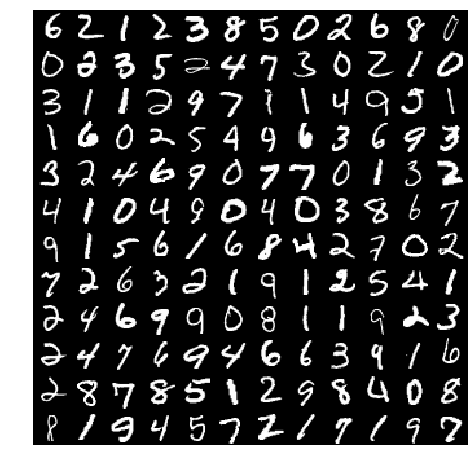

In [6]:
square = 12
indexes = random.sample(range(len(trainingData)), square* square)
images = [numpy.array(trainingData[i][0], dtype='uint8') for i in indexes]
for image in images:
    image.resize(28,28) 
images = [Image.fromarray(i) for i in images]    

total_square = square * 28

compImage = Image.new('L', (total_square,total_square))

x_offset = 0
y_offset = 0
for im in images:
    compImage.paste(im, (x_offset,y_offset))
    x_offset += im.size[0]
    if(x_offset == square*28):
        x_offset = 0 
        y_offset += im.size[0]

plt.figure(figsize=(8,8)) 
plt.axis('off')
plt.imshow(compImage)

# Train Model

In [7]:
#Create Network
network = Network([784, 30, 10])

#Train Model
batchSize = 10
epochs = 25
learningRate = 3.0
trainingResults, testingResults = network.Train(trainingData, testingData, epochs, batchSize, learningRate)

Train Data Size: 60000
Test Data Size: 10000
Epoch 0) Train - Accuracy: 56.05% & Loss: 0.62272 | Test - Accuracy: 56.66% & Loss: 0.61716
Epoch 1) Train - Accuracy: 57.83% & Loss: 0.59441 | Test - Accuracy: 58.82% & Loss: 0.58676
Epoch 2) Train - Accuracy: 57.90% & Loss: 0.59923 | Test - Accuracy: 58.28% & Loss: 0.59349
Epoch 3) Train - Accuracy: 58.74% & Loss: 0.59105 | Test - Accuracy: 59.25% & Loss: 0.58543
Epoch 4) Train - Accuracy: 56.73% & Loss: 0.61574 | Test - Accuracy: 57.68% & Loss: 0.60937
Epoch 5) Train - Accuracy: 55.63% & Loss: 0.63442 | Test - Accuracy: 56.56% & Loss: 0.62393
Epoch 6) Train - Accuracy: 55.83% & Loss: 0.63251 | Test - Accuracy: 56.65% & Loss: 0.62565
Epoch 7) Train - Accuracy: 57.20% & Loss: 0.60695 | Test - Accuracy: 58.16% & Loss: 0.59777
Epoch 8) Train - Accuracy: 58.27% & Loss: 0.59638 | Test - Accuracy: 58.58% & Loss: 0.59125
Epoch 9) Train - Accuracy: 58.66% & Loss: 0.59539 | Test - Accuracy: 59.20% & Loss: 0.58836
Epoch 10) Train - Accuracy: 58.10% 

# Plot Loss and % Correct

<Figure size 432x288 with 0 Axes>

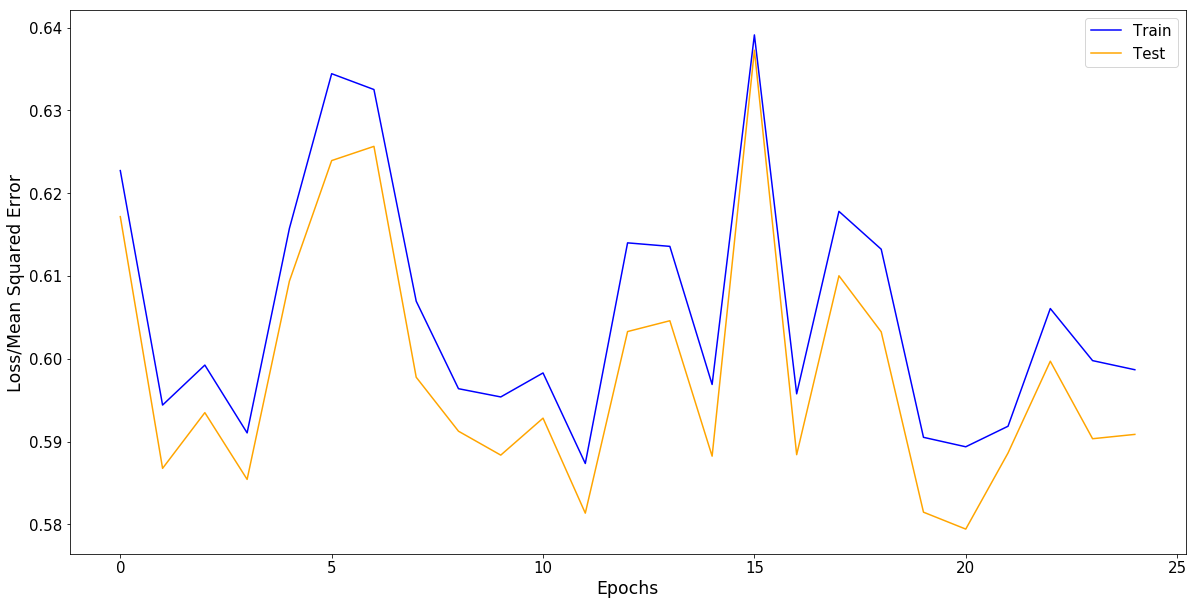

In [8]:
plt.clf()
plt.figure(figsize=(20,10)) 
plt.plot(trainingResults[1], color="blue", label="Train")
plt.plot(testingResults[1], color="orange", label="Test")
plt.ylabel("Loss/Mean Squared Error", fontsize="xx-large")
plt.xlabel("Epochs", fontsize="xx-large")
plt.tick_params(labelsize=15)
plt.legend(prop={'size': 15})
plt.show()

<Figure size 432x288 with 0 Axes>

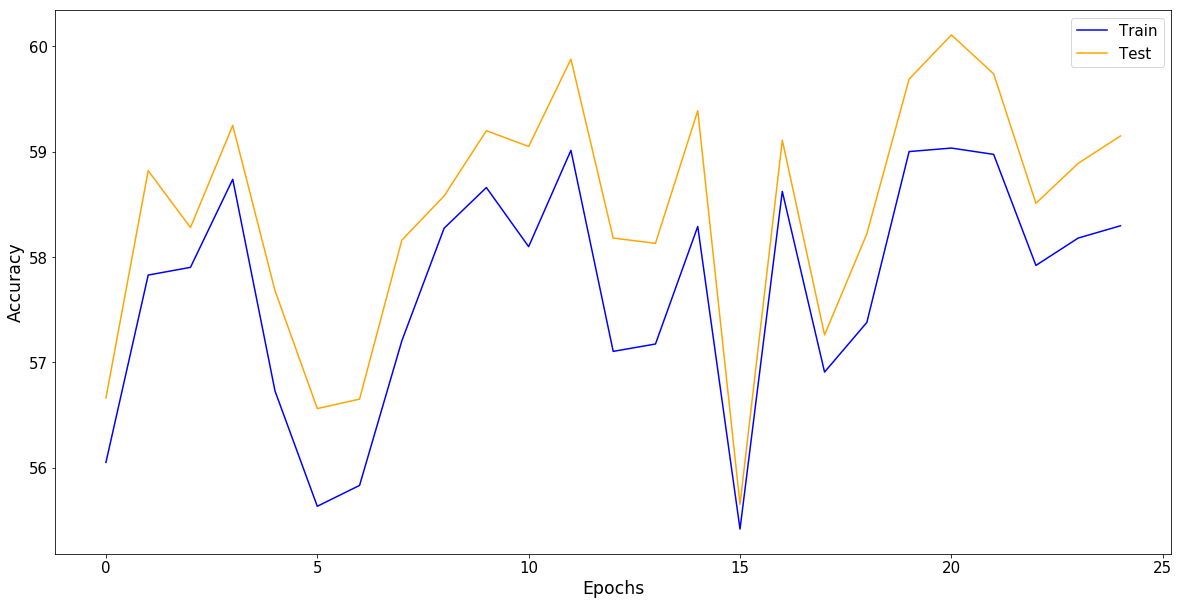

In [9]:
plt.clf()
plt.figure(figsize=(20,10)) 
plt.plot([x/len(trainingData)*100 for x in trainingResults[0]], color="blue", label="Train")
plt.plot([x/len(testingData)*100 for x in testingResults[0]], color="orange", label="Test")
plt.ylabel("Accuracy", fontsize="xx-large")
plt.xlabel("Epochs", fontsize="xx-large")
plt.tick_params(labelsize=15)
plt.legend(prop={'size': 15})
plt.show()

In [10]:
trainingResults[1]

[0.6227242615191554,
 0.5944065224135722,
 0.5992345393080102,
 0.591046708555962,
 0.6157359162304804,
 0.6344244252288364,
 0.6325140825119846,
 0.606949521612848,
 0.5963831235792615,
 0.5953881446235534,
 0.5982858556669962,
 0.5873520555417424,
 0.6139962508937319,
 0.6135722948984575,
 0.5968931135457656,
 0.6391099102652056,
 0.5957629839425956,
 0.6178004947359883,
 0.6132282718734509,
 0.5905114476347576,
 0.5893692316311564,
 0.5918500116603675,
 0.6060654870221626,
 0.59977447589097,
 0.598674212995905]

In [11]:
testingResults[1]

[0.617164557112997,
 0.5867637296500804,
 0.5934912627814775,
 0.5854302866015146,
 0.6093701340283949,
 0.6239328927821449,
 0.6256501971019316,
 0.5977683105256965,
 0.5912506164483964,
 0.5883624261681553,
 0.5928260456259743,
 0.5813543296194821,
 0.6032843788852593,
 0.6045899944022877,
 0.5882360739447576,
 0.6372586773003734,
 0.5884139526590019,
 0.6100207716062094,
 0.6032482697016947,
 0.5814711267243301,
 0.5794288761291475,
 0.5886188312086117,
 0.5997020193930598,
 0.5903424016521406,
 0.5908655337336967]